# Gaussian process regression: Implementation using GPyTorch   
    
GPyTorch is a Gaussian process library implemented using PyTorch. GPyTorch is designed for creating scalable, flexible, and modular Gaussian process models with ease (https://github.com/cornellius-gp/gpytorch). GPyTorch provides significant GPU acceleration (through MVM based inference) and state-of-the-art implementations of the latest algorithmic advances for scalability and flexibility.   
   
We used GpyTorch to easily build models of GP regression and especially the exact GP regression (see MyGPModel.py), the PP methpd/Nyström approximate model (see NystromSparseGP.py) and the Titsias model (see TitisasSparseGP.py). The main objective of this notebook is to show some basic uses of GPyTorch and the models we implemented with simple datasets.

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import copy

from gpytorch import priors ,likelihoods, mlls
from models.gpyt_sparse import TitsiasSparseGP, NystromSparseGP
from models.gpyt_regressor import MyGPModel

import matplotlib.pyplot as plt
plt.style.use("seaborn")

## 1. Simple datatset

In [11]:
df_train = pd.read_csv("simple_example/Simple_train.csv")

X_train, y_train = torch.from_numpy(df_train['X'].values).float(), torch.from_numpy(df_train['Y'].values).float()

df_test = pd.read_csv("simple_example/Simple_test.csv")

X_test , y_test = torch.from_numpy(df_test['X'].values).float()  ,df_test['X'].values

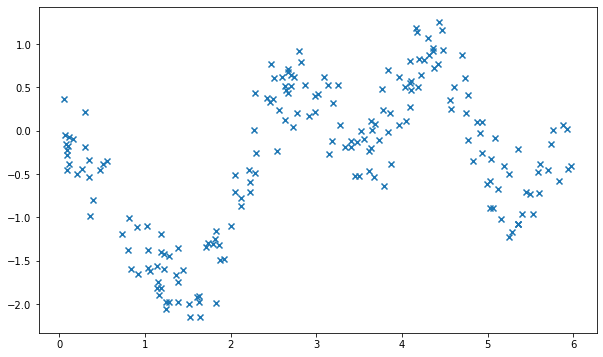

In [4]:
plt.figure(figsize=(10 , 6))
plt.scatter(df_train['X'] , df_train['Y'] , marker = 'x')

### 1.A Exact Gaussian Process Regression

In [6]:
# Define the model
regression_loss = likelihoods.GaussianLikelihood()
model = MyGPModel(X_train, y_train, regression_loss)
model.train()
regression_loss.train()

# Define the marginal log-likelihood for the hyperparameters
hyp_loss = mlls.ExactMarginalLogLikelihood(regression_loss, model)

In [7]:
# Define the optimizer (here we chose Adam optimizer) and the number of epochs
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

#Run the optimizer for 100 epochs in order to optimize the hyperparameters using loss = - marginal log-likelihood
eprange = tqdm.notebook.tqdm_notebook(range(epochs))
losses_record = []
for i in eprange:
    output = model(X_train)
    loss = -hyp_loss(output, y_train)
    loss.backward()

    eprange.set_postfix({"mll": loss.data.item()})
    losses_record.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()

{'likelihood.noise_covar.raw_noise': Parameter containing:
 tensor([-2.4805], requires_grad=True),
 'model.covar_module.raw_outputscale': Parameter containing:
 tensor(0.1213, requires_grad=True),
 'model.covar_module.base_kernel.raw_lengthscale': Parameter containing:
 tensor([[-0.1804]], requires_grad=True)}

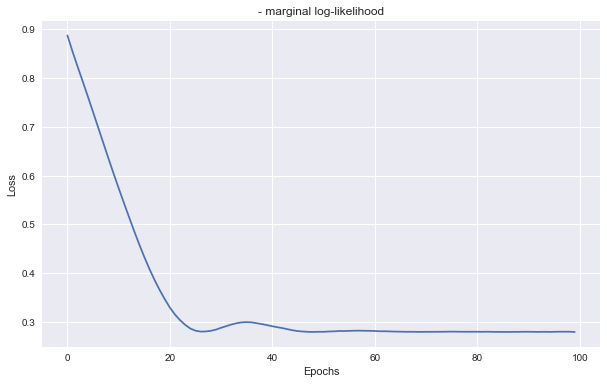

In [16]:
# Plot the loss with respect to the number of epochs
plt.figure(figsize = (10 , 6))
plt.plot(losses_record)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("- marginal log-likelihood for exact GP")

# Print the optimal values of the hyperparameters
dict(hyp_loss.named_hyperparameters())

In [18]:
def make_prediction(model, x_pred):
    """Return predictive distribution at points `x_pred`."""
    return regression_loss(model(x_pred))

model.eval()
regression_loss.eval()
y_pred_test = make_prediction(model, X_test)

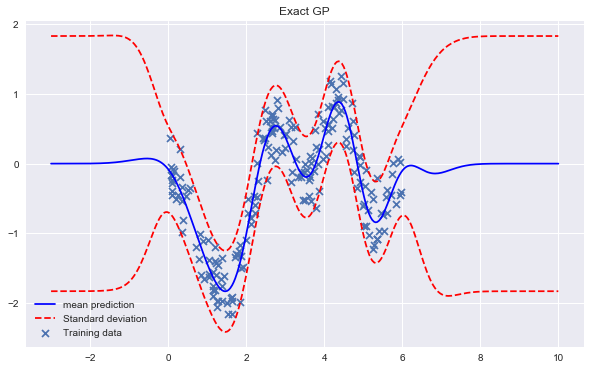

In [19]:
plt.figure(figsize=(10 , 6))
plt.scatter(X_train.data, y_train.data, marker = 'x' ,label = 'Training data')
plt.plot(X_test.data, y_pred_test.mean.data, 'b' , label = 'mean prediction')
lower, upper = y_pred_test.confidence_region()
lower.detach_()
upper.detach_()

plt.plot(X_test.data, lower, '--' ,  color='red' , label = 'Standard deviation')
plt.plot(X_test.data, upper, '--' , color='red')
min_lower_std = torch.min(lower) - 0.1
plt.title("Exact GP")
plt.legend()

### 1.B Nystrom approximate Gaussian Process regression (PP) vs Titsias variational regression

**Important Note**: Contrary to what is described in section 3.1 of Titsias 2009, Gpytorch does not use a greedy algorithm to select the induced points. Instead, it directly optimizes the variational lower bound. Thus we need to specify initial induced points (inducing_points_priors).

In [66]:
# Define the model (for PP regression we need to specify initial inducing points)
regression_loss = likelihoods.GaussianLikelihood()
inducing_points = X_train[torch.multinomial(X_train, 10)]
inducing_points_prior = copy.deepcopy(inducing_points)

model = NystromSparseGP(X_train, y_train, inducing_points_prior, regression_loss)
#model = TitsiasSparseGP(X_train, y_train, inducing_points_prior, regression_loss)
model.train()
regression_loss.train()

# Define the marginal log-likelihood for the hyperparameters
hyp_loss = mlls.ExactMarginalLogLikelihood(regression_loss, model)

In [67]:
# Define the optimizer (here we chose Adam optimizer) and the number of epochs
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

#Run the optimizer for 100 epochs in order to optimize the hyperparameters using loss = - marginal log-likelihood
eprange = tqdm.notebook.tqdm_notebook(range(epochs))
losses_record = []
for i in eprange:
    output = model(X_train)
    loss = -hyp_loss(output, y_train)
    loss.backward()
    
    eprange.set_postfix({"mll": loss.data.item()})
    losses_record.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()

{'likelihood.noise_covar.raw_noise': Parameter containing:
 tensor([-2.6391], requires_grad=True),
 'model.base_cov_module.raw_outputscale': Parameter containing:
 tensor(0.1663, requires_grad=True),
 'model.base_cov_module.base_kernel.raw_lengthscale': Parameter containing:
 tensor([[-0.1495]], requires_grad=True),
 'model.covar_module.inducing_points': Parameter containing:
 tensor([[5.3340],
         [0.0427],
         [1.8728],
         [1.2583],
         [0.9317],
         [2.7830],
         [3.7332],
         [3.8631],
         [5.2196],
         [5.0919]], requires_grad=True)}

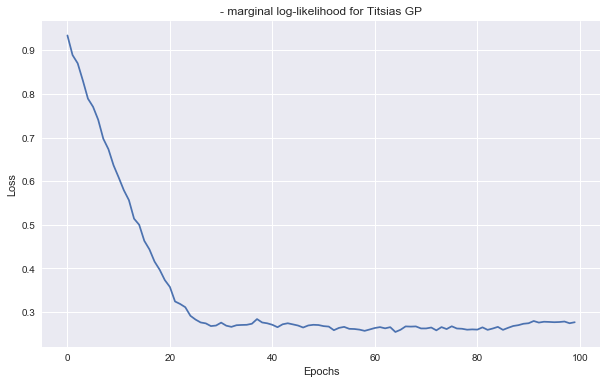

In [68]:
# Plot the loss with respect to the number of epochs
plt.figure(figsize = (10 , 6))
plt.plot(losses_record)
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.title("- marginal log-likelihood for Nyström GP")
plt.title("- marginal log-likelihood for Titsias GP")


# Print the optimal values of the hyperparameters
dict(hyp_loss.named_hyperparameters())

In [69]:
model.eval()
regression_loss.eval()
y_pred_test = make_prediction(model, X_test)

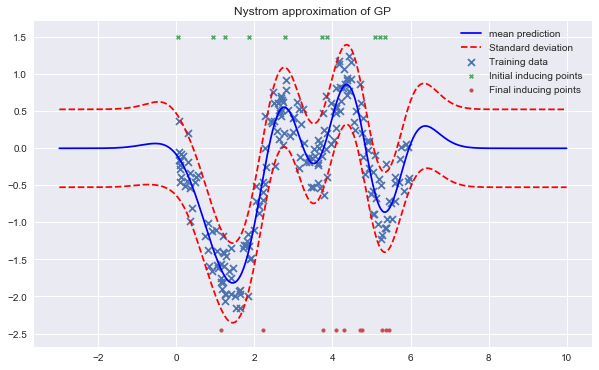

In [70]:
plt.figure(figsize=(10 , 6))
plt.scatter(X_train.data, y_train.data, marker = 'x' ,label = 'Training data')
plt.plot(X_test.data, y_pred_test.mean.data, 'b' , label = 'mean prediction')
lower, upper = y_pred_test.confidence_region()
lower.detach_()
upper.detach_()

plt.plot(X_test.data, lower, '--' ,  color='red' , label = 'Standard deviation')
plt.plot(X_test.data, upper, '--' , color='red')
min_lower_std = torch.min(lower) - 0.1
max_upper_std = torch.max(upper) + 0.1
plt.scatter(inducing_points_prior, max_upper_std*torch.ones_like(inducing_points_prior),
            s=14, marker="x", label="Initial inducing points")
plt.scatter(inducing_points, min_lower_std*torch.ones_like(inducing_points),
            s=14, marker="o", label="Final inducing points")
plt.title("Nystrom approximation of GP")
plt.legend()